# Handwritten Digit Recognition with Deep Learning
### Using MNIST + Multiple Deep Learning Techniques

In this notebook, I explore several deep learning techniques to classify handwritten digits (0–9) from the MNIST dataset.

I build and compare:

1. **Baseline Fully Connected Neural Network (Dense layers)**
2. **Convolutional Neural Network (CNN)**
3. **Regularized CNN** (Batch Normalization + Dropout)
4. **CNN with Data Augmentation**
5. **Autoencoder for representation learning (compression + reconstruction)**

The goals are:

- Understand how different architectures affect performance  
- Practice regularization and data augmentation  
- Visualize model behavior, errors, and learned representations  
- Generate plots & results suitable for a LinkedIn post or portfolio


In [44]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [45]:
# load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)


Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


# MNIST Dataset Overview

The MNIST dataset contains **70,000** grayscale images of handwritten digits:
- **60,000 for training**
- **10,000 for testing**

Each image:
- Size: **28 × 28 pixels**
- Grayscale (values 0–255)
- Label: integer **0–9**

I'll start by visualizing some examples.


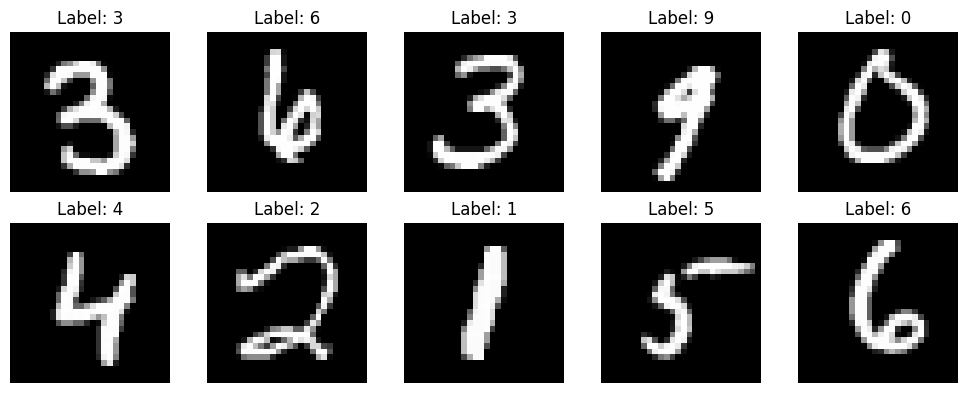

In [46]:
# this shows a grid of random MNIST samples
num_rows, num_cols = 2, 5
num_images = num_rows * num_cols

plt.figure(figsize=(num_cols * 2, num_rows * 2))

indices = np.random.choice(len(x_train), num_images, replace=False)

for i, idx in enumerate(indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(x_train[idx], cmap="gray")
    plt.title(f"Label: {y_train[idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Data Preprocessing

Before training, I perform basic preprocessing:

1. **Convert to float** — models train better with floating-point numbers.  
2. **Normalize pixel values** — divide by 255.0 to scale values to [0, 1].  
3. **Reshape data depending on the model**:
   - For the **fully connected network**, I flattened each image to a 784-D vector.
   - For the **CNN**, I keep the 2D structure and add a channel dimension: (28, 28, 1).


In [47]:
# convert to float32 and normalize to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# flattering the data for dense models
x_train_flat = x_train.reshape(-1, 28 * 28)
x_test_flat = x_test.reshape(-1, 28 * 28)

# adding a channel dimension for CNNs: (H, W, 1)
x_train_cnn = np.expand_dims(x_train, -1)  # shape: (60000, 28, 28, 1)
x_test_cnn = np.expand_dims(x_test, -1)    # shape: (10000, 28, 28, 1)

num_classes = 10

print("x_train_flat shape:", x_train_flat.shape)
print("x_train_cnn shape:", x_train_cnn.shape)


x_train_flat shape: (60000, 784)
x_train_cnn shape: (60000, 28, 28, 1)


# Helper Function: Plot Training Curves

Here, I'll define a small helper to visualize **training vs validation** accuracy and loss curves for any model that I will train.


In [48]:
def plot_training_curves(history, title_prefix="Model"):
    """Plot training & validation accuracy and loss for a Keras History object."""
    acc = history.history.get("accuracy")
    val_acc = history.history.get("val_accuracy")
    loss = history.history.get("loss")
    val_loss = history.history.get("val_loss")
    epochs = range(1, len(acc) + 1)

    # accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, acc, label="Training accuracy")
    plt.plot(epochs, val_acc, label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # loss
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, loss, label="Training loss")
    plt.plot(epochs, val_loss, label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Baseline Model - Fully Connected Neural Network

First, I build a simple **fully connected neural network** that treats each image as a 784-dimensional vector.

### Architecture:
- Input: 784 (flattened 28×28)
- Dense(128, ReLU)
- Dense(64, ReLU)
- Dense(10, Softmax) — probability for each digit (0–9)

This model ignores spatial structure but serves as a **baseline** to compare against CNNs.


In [49]:
baseline_model = keras.Sequential([
    layers.Input(shape=(784,)),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

baseline_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

baseline_model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
baseline_history = baseline_model.fit(
    x_train_flat,
    y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=32,
    verbose=1
)


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9241 - loss: 0.2589 - val_accuracy: 0.9667 - val_loss: 0.1111
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9657 - loss: 0.1096 - val_accuracy: 0.9700 - val_loss: 0.0956
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9775 - loss: 0.0746 - val_accuracy: 0.9738 - val_loss: 0.0850
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9817 - loss: 0.0582 - val_accuracy: 0.9753 - val_loss: 0.0898
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9854 - loss: 0.0445 - val_accuracy: 0.9797 - val_loss: 0.0730


In [51]:
baseline_test_loss, baseline_test_acc = baseline_model.evaluate(x_test_flat, y_test, verbose=0)
print(f"Baseline Test accuracy: {baseline_test_acc:.4f}")


Baseline Test accuracy: 0.9764


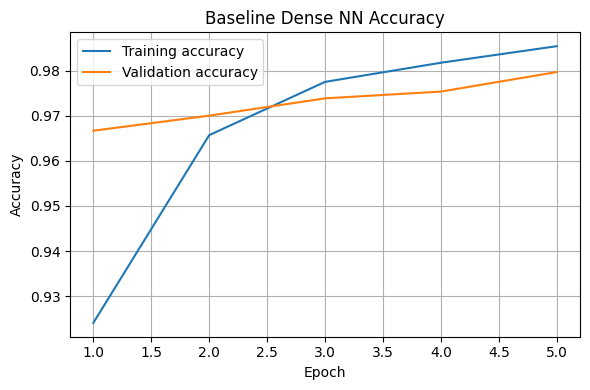

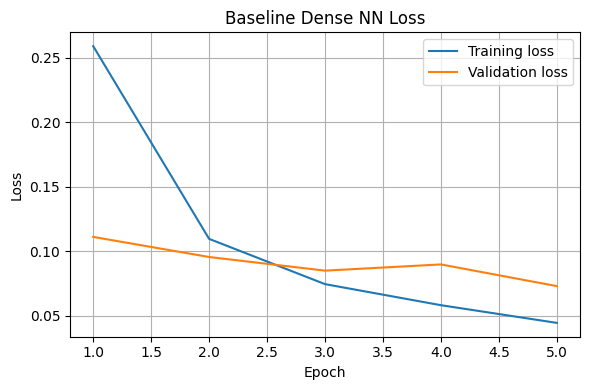

In [52]:
plot_training_curves(baseline_history, title_prefix="Baseline Dense NN")


# Convolutional Neural Network (CNN)

Fully connected networks ignore 2D structure in images.  
A **CNN** uses convolutional filters to learn local patterns like edges, corners, and strokes.

### Architecture:
- Input: (28, 28, 1)
- Conv2D(32, 3×3, ReLU) + MaxPooling2D(2×2)
- Conv2D(64, 3×3, ReLU) + MaxPooling2D(2×2)
- Flatten
- Dense(128, ReLU)
- Dense(10, Softmax)

This model typically outperforms the dense network on image tasks.


In [53]:
cnn_model = keras.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

cnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_model.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
cnn_history = cnn_model.fit(
    x_train_cnn,
    y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=64,
    verbose=1
)


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9485 - loss: 0.1717 - val_accuracy: 0.9835 - val_loss: 0.0522
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9846 - loss: 0.0499 - val_accuracy: 0.9878 - val_loss: 0.0425
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9890 - loss: 0.0340 - val_accuracy: 0.9897 - val_loss: 0.0356
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9916 - loss: 0.0259 - val_accuracy: 0.9908 - val_loss: 0.0322
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9938 - loss: 0.0190 - val_accuracy: 0.9893 - val_loss: 0.0353


In [55]:
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(x_test_cnn, y_test, verbose=0)
print(f"CNN Test accuracy: {cnn_test_acc:.4f}")


CNN Test accuracy: 0.9896


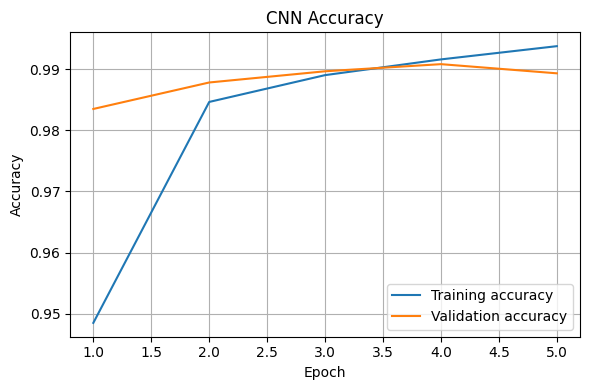

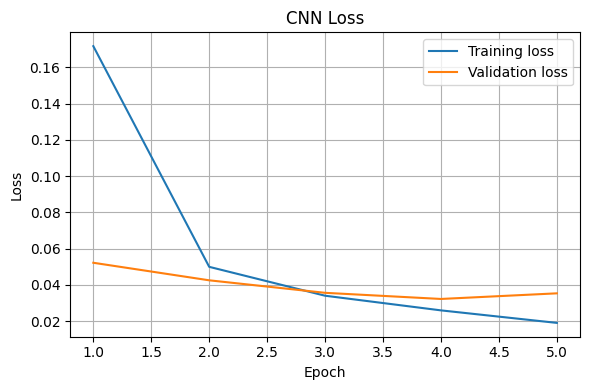

In [56]:
plot_training_curves(cnn_history, title_prefix="CNN")


# Regularized CNN - Batch Normalization & Dropout

To reduce overfitting and improve generalization, I add:

- **Batch Normalization (BN)**  
  Normalizes layer activations, stabilizes training, and allows deeper networks.

- **Dropout**  
  Randomly drops neurons during training (e.g., 25% or 50%), which:
  - Prevents co-adaptation  
  - Forces the network to learn more robust features

This should give more stable training curves and strong performance on the test set.


In [57]:
reg_model = keras.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax")
])

reg_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

reg_model.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,930 (882.54 KB)

 Trainable params: 225,482 (880.79 KB)

 Non-trainable params: 448 (1.75 KB)

In [58]:
reg_history = reg_model.fit(
    x_train_cnn,
    y_train,
    validation_split=0.1,
    epochs=10,           # more epochs, regularization helps avoid overfitting
    batch_size=64,
    verbose=1
)


Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.9296 - loss: 0.2322 - val_accuracy: 0.9843 - val_loss: 0.0542
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9725 - loss: 0.0897 - val_accuracy: 0.9900 - val_loss: 0.0335
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9780 - loss: 0.0697 - val_accuracy: 0.9895 - val_loss: 0.0349
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9814 - loss: 0.0626 - val_accuracy: 0.9898 - val_loss: 0.0346
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9826 - loss: 0.0553 - val_accuracy: 0.9912 - val_loss: 0.0291
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9841 - loss: 0.0500 - val_accuracy: 0.9903 - val_loss: 0.0345
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9863 - loss: 0.0429 - val_accuracy: 0.9920 - val_loss: 0.0284
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9863 - loss: 0.0432 - 

In [59]:
reg_test_loss, reg_test_acc = reg_model.evaluate(x_test_cnn, y_test, verbose=0)
print(f"Regularized CNN Test accuracy: {reg_test_acc:.4f}")


Regularized CNN Test accuracy: 0.9934


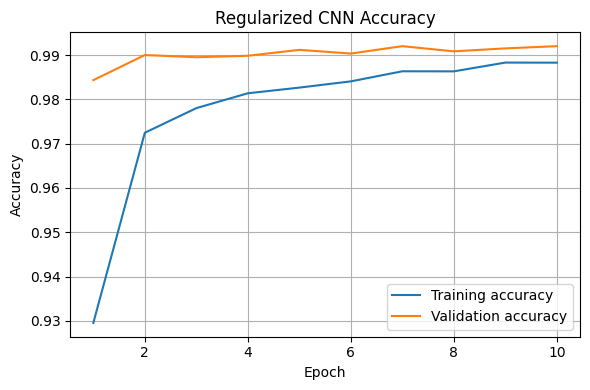

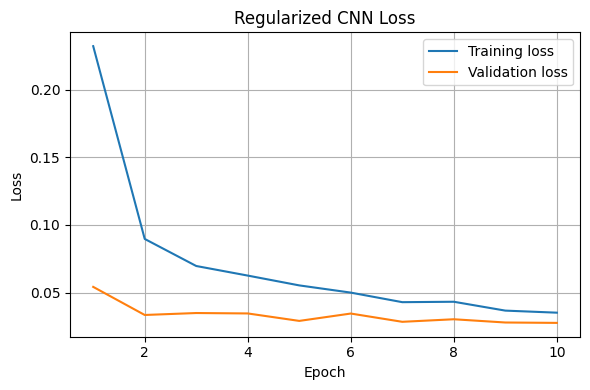

In [60]:
plot_training_curves(reg_history, title_prefix="Regularized CNN")


# Data Augmentation

To make the model more robust, I apply **data augmentation**:

- Small random rotations
- Horizontal/vertical shifts
- Zoom in/out

This simulates different handwriting styles and improves generalization.  
I only augment the **training data**, not the test data.


In [61]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

datagen.fit(x_train_cnn)


In [62]:
def create_regularized_cnn():
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

aug_model = create_regularized_cnn()
aug_model.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,930 (882.54 KB)

 Trainable params: 225,482 (880.79 KB)

 Non-trainable params: 448 (1.75 KB)

In [63]:
batch_size = 64

aug_history = aug_model.fit(
    datagen.flow(x_train_cnn, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train_cnn) // batch_size,
    epochs=10,
    validation_data=(x_test_cnn, y_test),
    verbose=1
)


Epoch 1/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.8579 - loss: 0.4570 - val_accuracy: 0.9762 - val_loss: 0.0762
Epoch 2/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8906 - loss: 0.3307 - val_accuracy: 0.9764 - val_loss: 0.0746
Epoch 3/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.9433 - loss: 0.1846 - val_accuracy: 0.9880 - val_loss: 0.0367
Epoch 4/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9688 - loss: 0.0815 - val_accuracy: 0.9884 - val_loss: 0.0360
Epoch 5/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9557 - loss: 0.1451 - val_accuracy: 0.9893 - val_loss: 0.0331
Epoch 6/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9531 - loss: 0.1751 - val_accuracy: 0.9889 - val_loss: 0.0338
Epoch 7/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9624 - loss: 0.1243 - val_accuracy: 0.9913 - val_loss: 0.0275
Epoch 8/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9688 - loss: 0.1233 - val_accu

In [64]:
aug_test_loss, aug_test_acc = aug_model.evaluate(x_test_cnn, y_test, verbose=0)
print(f"Augmented CNN Test accuracy: {aug_test_acc:.4f}")


Augmented CNN Test accuracy: 0.9916


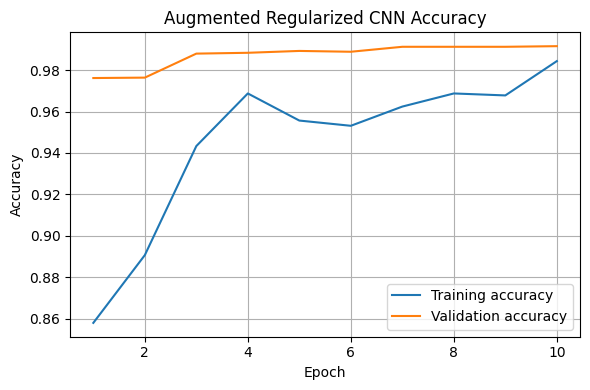

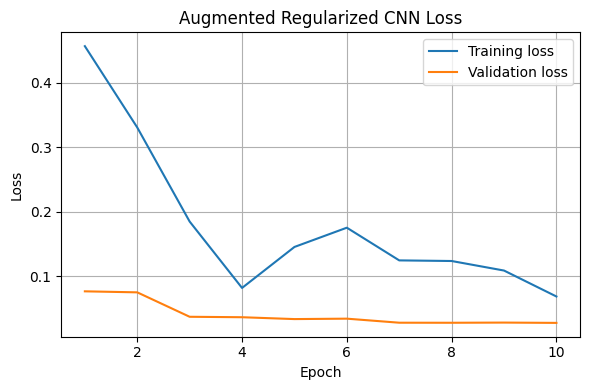

In [65]:
plot_training_curves(aug_history, title_prefix="Augmented Regularized CNN")


# Analyzing Misclassified Digits

Even a strong model will sometimes predict incorrectly.

I will
- Use my best model (likely the augmented regularized CNN)
- Find test images where the predicted label ≠ true label
- Visualize a grid of misclassified digits with true & predicted labels

In [66]:
# choosing to analyse augumented model
model_to_check = aug_model  

# get predictions on test set
y_pred_probs = model_to_check.predict(x_test_cnn)
y_pred = np.argmax(y_pred_probs, axis=1)

# find misclassified indices
misclassified_indices = np.where(y_pred != y_test)[0]
print(f"Total misclassified samples: {len(misclassified_indices)}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Total misclassified samples: 84


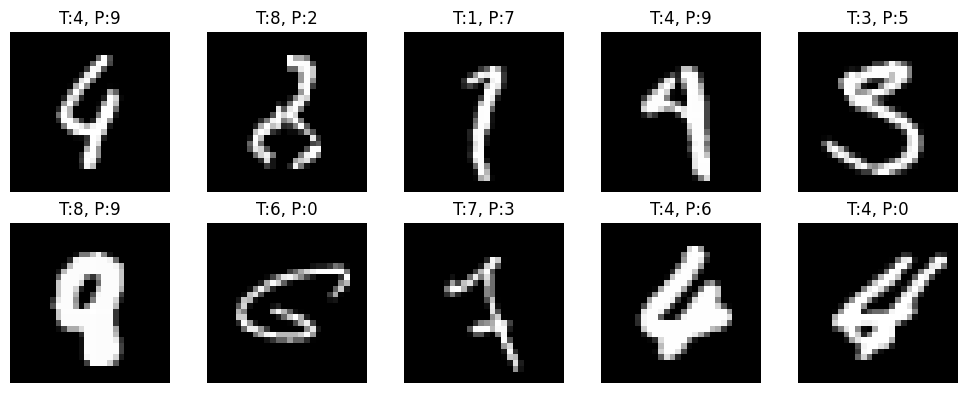

In [67]:
# show some misclassified images
num_rows, num_cols = 2, 5
num_images = num_rows * num_cols
selected_indices = misclassified_indices[:num_images]

plt.figure(figsize=(num_cols * 2, num_rows * 2))

for i, idx in enumerate(selected_indices):
    plt.subplot(num_rows, num_cols, i + 1)
    image = x_test_cnn[idx].squeeze()
    true_label = y_test[idx]
    pred_label = y_pred[idx]
    plt.imshow(image, cmap="gray")
    plt.title(f"T:{true_label}, P:{pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Autoencoder - Learning Compressed Representations

Now I build an **autoencoder**:

- **Encoder**: compresses a 784-dimensional input into a smaller latent vector (e.g., 32 dimensions).
- **Decoder**: reconstructs the original 784-dimensional vector from the latent vector.

Trained to minimize reconstruction error, autoencoders learn meaningful internal representations of digits.

We then compare:
- Original digit images  
- Their reconstructed versions  

In [68]:
encoding_dim = 32  # size of the latent space

input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation="relu")(input_img)
encoded = layers.Dense(encoding_dim, activation="relu")(encoded)

decoded = layers.Dense(128, activation="relu")(encoded)
decoded = layers.Dense(784, activation="sigmoid")(decoded)

autoencoder = keras.Model(input_img, decoded)

autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.summary()


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,968 (820.19 KB)

 Trainable params: 209,968 (820.19 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
autoencoder_history = autoencoder.fit(
    x_train_flat,
    x_train_flat,
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test_flat, x_test_flat),
    verbose=1
)


Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0602 - val_loss: 0.0340
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0268 - val_loss: 0.0211
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0197 - val_loss: 0.0176
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0170 - val_loss: 0.0156
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0152 - val_loss: 0.0141
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0141 - val_loss: 0.0133
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0134 - val_loss: 0.0127
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0129 - val_loss: 0.0124
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0126 - val_loss: 0.0121
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0123 - val_loss: 0.0118


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


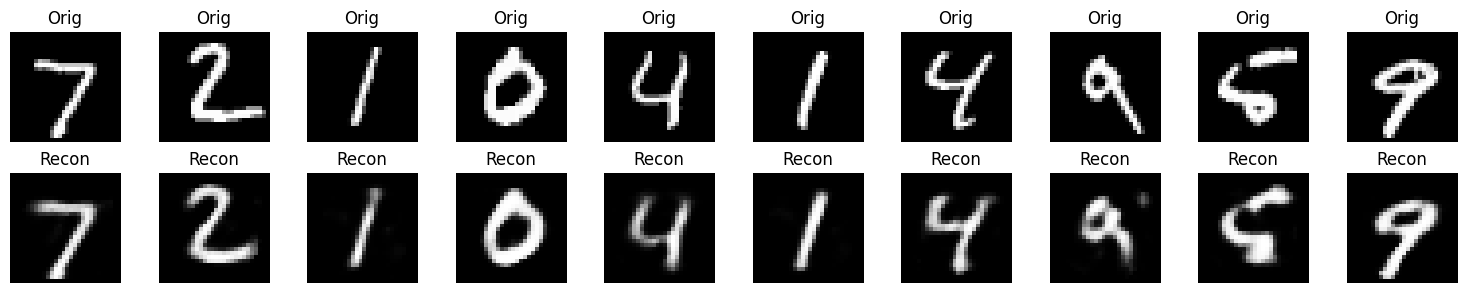

In [70]:
# number of test examples to visualize
num_examples = 10

test_samples = x_test_flat[:num_examples]

# reconstruct using the autoencoder
reconstructions = autoencoder.predict(test_samples)

# reshape to 28x28 images
test_images = test_samples.reshape(-1, 28, 28)
reconstructed_images = reconstructions.reshape(-1, 28, 28)

plt.figure(figsize=(num_examples * 1.5, 3))

# top row: original images
for i in range(num_examples):
    plt.subplot(2, num_examples, i + 1)
    plt.imshow(test_images[i], cmap="gray")
    plt.title("Orig")
    plt.axis("off")

# bottom row: reconstructed images
for i in range(num_examples):
    plt.subplot(2, num_examples, num_examples + i + 1)
    plt.imshow(reconstructed_images[i], cmap="gray")
    plt.title("Recon")
    plt.axis("off")

plt.tight_layout()
plt.show()
